# GMAC Acceleration Magnitude: Grid search of GMAC parameters

The acceleration magnitude estimation for the GMAC algorithm has the following parameters:
1. Butteworth highpass filter cut-off for accl. mag. estimation. $\left( f_{c} \right)$
2. Butteworth highpass filter order for accl. mag. estimation. $\left( n_{c} \right)$
3. Acceleration deadband threshold. $\left( a_{th0} \right)$
4. Moving average window for acceleration magnitude estimation. $\left( n_{am} \right)$

### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib
import itertools
import glob

In [3]:
import seaborn as sns

### Custom Modules

In [4]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc

In [5]:
import gmac

In [6]:
# Define the font family and size
# font = {'family': 'sans-serif', 'sans-serif': ['Helvetica']}

# # Set the font properties for various elements
# plt.rc('font', **font)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight


## Define notebook level constants

In [7]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)

## Read the Controls and Patients Data

In [8]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

# All limbs data ddf
datadf = {
    "left": left,
    "right": right,
    "aff": aff,
    "unaff": unaff
}

In [9]:
# Generate all possible combinations of parameters.
def generate_param_combinations(param_ranges: dict) -> dict:
    """
    Generate all possible combinations of parameters.
    """
    for _fc in param_ranges["fc"]:
        for _nc in param_ranges["nc"]:
            for _nam in param_ranges["nam"]:
                yield {
                    "fc": _fc,
                    "nc": int(_nc),
                    "nam": int(_nam)
                }

#### Parameter ranges for the grid search

In [11]:
basedir = "../data/output-new"
# limbkey = "unaff"

# GMAC Parameter ranges
am_param_ranges = {
    "fc": [0.01, 0.1, 1],
    "nc": [1, 2, 4],
    "nam": list(map(int, [Fs, 5*Fs, 10*Fs]))
}

In [12]:
for limbkey in ["left", "right", "aff", "unaff"]:
    # Make directory if it does not exist
    outdir = pathlib.Path(basedir, limbkey, "am")
    outdir.mkdir(parents=True, exist_ok=True)

    # Which limb?
    limbdf = datadf[limbkey]
    subjects = limbdf.subject.unique()

    # Number of all possible combinations
    Ncombs = len(list(generate_param_combinations(am_param_ranges)))

    # All parameter combinations.
    param_combs = list(generate_param_combinations(am_param_ranges))

    # Estimate pitch for each subject.
    accl_cols = ['ax', 'ay', 'az']
    dfcols = ["subject"] + list(am_param_ranges.keys()) + ["am", "vm"]

    for i, subj in enumerate(subjects):
        am_df = pd.DataFrame(columns=dfcols)
        # Go through all parameter combinations.
        _sinx = limbdf.subject == subj
        for j, _pc in enumerate(param_combs):
            sys.stdout.write(f"\r{limbkey} {i:3d}, {j:3d}")
            df = limbdf[limbdf.subject==subj]
            # Compute the vector magnitude
            _vmdf = misc.compute_vector_magnitude(df)
            # Compute the accl magnitude
            _tempam = gmac.estimate_accl_mag(accl=df[accl_cols].values,
                                            fs=Fs, fc=_pc["fc"], nc=_pc["nc"],
                                            n_am=_pc["nam"])
            _tempamdf = pd.DataFrame(np.vstack((_tempam, df.segment.values)).T,
                                    columns=["am", "segment"], index=df.index)
            # Resample accl magnitude to the same frequency as vector magnitude
            _amdf = pd.concat([_y.resample(str(1) + 'S').sum()
                            for _, _y in _tempamdf.groupby('segment')])
            
            # Merge the two dataframes
            _tempdf = pd.merge(_vmdf, _amdf["am"], left_index=True, right_index=True)

            # Update amdf
            _n = len(_tempdf)
            _subj_am = np.hstack((subj * np.ones((_n, 1)),
                                _pc["fc"] * np.ones((_n, 1)),
                                _pc["nc"] * np.ones((_n, 1)),
                                _pc["nam"] * np.ones((_n, 1)),
                                _tempdf.am.values.reshape(-1, 1),
                                _tempdf.counts.values.reshape(-1, 1)))
            am_df = pd.concat((am_df, pd.DataFrame(_subj_am, columns=dfcols)),
                            ignore_index=True)
        # Save data regularly
        am_df.to_csv(pathlib.Path(outdir, f"{subj}-am.csv").as_posix(), index=False)


unaff   4,  26

In [13]:
# Read and combine data from different subjects in one file.
_path = pathlib.Path(basedir, "left", "am").as_posix() + "/*-am.csv"
all_am_df = {
    _lmb: pd.concat([pd.read_csv(f) for f in glob.glob(pathlib.Path(basedir, _lmb, "am").as_posix()
                                                       + "/*-am.csv")],
                    ignore_index=True)
    for _lmb in ["left", "right", "aff", "unaff"]
}

In [14]:
# Compute correlation for all limbs
am_corr_df = {}
for _lmb in ["left", "right", "aff", "unaff"]:
    param_combs = list(generate_param_combinations(am_param_ranges))

    # Effect of fc
    _limbdf = all_am_df[_lmb]
    cols = ["subj", "fc", "nc", "nam", "r", "p"]
    am_corr_df[_lmb] = pd.DataFrame(columns=cols)
    for i, subj in enumerate(_limbdf["subject"].unique()):
        am_df = pd.DataFrame(columns=dfcols)
        # Go through all parameter combinations.
        _sinx = _limbdf.subject == subj
        for j, _pc in enumerate(param_combs):
            # Parameter index
            _pcinx = ((_limbdf["fc"] == _pc["fc"]) &
                      (_limbdf["nc"] == _pc["nc"]) &
                      (_limbdf["nam"] == _pc["nam"]))
            _vm = _limbdf.loc[_sinx & _pcinx]["vm"].values
            _am = _limbdf.loc[_sinx & _pcinx]["am"].values
            _inx = np.where(~np.isnan(_vm) & ~np.isnan(_am))[0]
            _r, _p = scipy.stats.pearsonr(_vm[_inx], _am[_inx])
            # Update amdf
            am_corr_df[_lmb] = pd.concat(
                (am_corr_df[_lmb],
                 pd.DataFrame(np.array([subj, _pc["fc"], _pc["nc"], _pc["nam"],
                                        _r, _p]).reshape(1, -1),
                              columns=cols)),
                ignore_index=True
            )

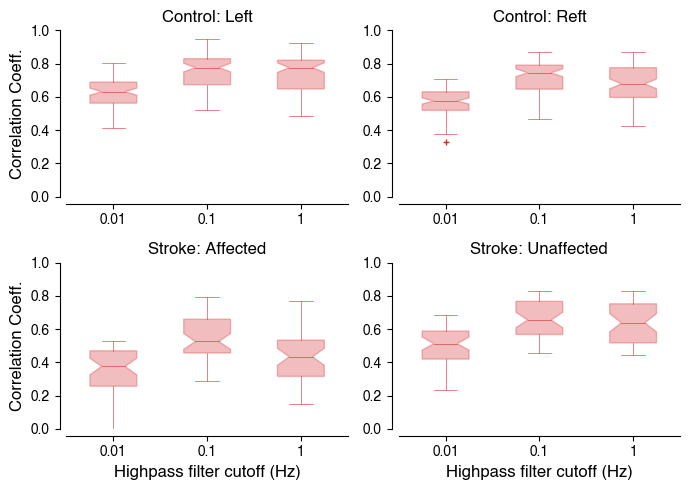

In [15]:
# Effect fc
fig = plt.figure(figsize=(7, 5))
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 2, j+1)
    for i, _val in enumerate(am_param_ranges["fc"]):
        _inx = am_corr_df[_lmb]["fc"] == _val
        _r = am_corr_df[_lmb][_inx]["r"].values
        ax.boxplot(x=_r, positions=[i],
                   widths=0.5, notch=True, patch_artist=True,
                   boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
                   capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                   whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                   flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                                   markerfacecolor='tab:red', marker='+', markersize=4),
                   medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
        ax.set_ylim(0.0, 1.0)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        ax.set_title(f"{_lmb}", fontsize=12)
        if _lmb == "left":
            ax.set_title("Control: Left", fontsize=12)
        elif _lmb == "right":
            ax.set_title("Control: Reft", fontsize=12)
        elif _lmb == "aff":
            ax.set_title("Stroke: Affected", fontsize=12)
        else:
            ax.set_title("Stroke: Unaffected", fontsize=12)
        
        if j // 2 == 1:
            ax.set_xlabel("Highpass filter cutoff (Hz)", fontsize=12)
        if j % 2 == 0:
            ax.set_ylabel("Correlation Coeff.", fontsize=12)

    ax.set_xticklabels(am_param_ranges["fc"])

plt.tight_layout()

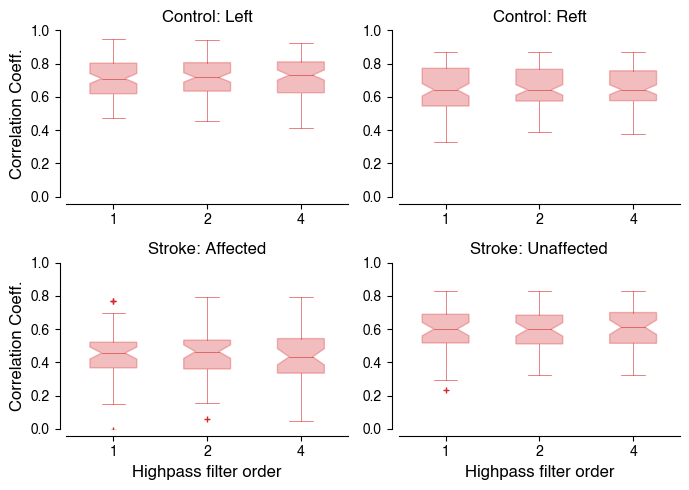

In [16]:
# Effect nc
fig = plt.figure(figsize=(7, 5))
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 2, j+1)
    for i, _val in enumerate(am_param_ranges["nc"]):
        _inx = am_corr_df[_lmb]["nc"] == _val
        _r = am_corr_df[_lmb][_inx]["r"].values
        ax.boxplot(x=_r, positions=[i],
                   widths=0.5, notch=True, patch_artist=True,
                   boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
                   capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                   whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                   flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                                   markerfacecolor='tab:red', marker='+', markersize=4),
                   medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
        ax.set_ylim(0.0, 1.0)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        ax.set_title(f"{_lmb}", fontsize=12)
        if _lmb == "left":
            ax.set_title("Control: Left", fontsize=12)
        elif _lmb == "right":
            ax.set_title("Control: Reft", fontsize=12)
        elif _lmb == "aff":
            ax.set_title("Stroke: Affected", fontsize=12)
        else:
            ax.set_title("Stroke: Unaffected", fontsize=12)
        
        if j // 2 == 1:
            ax.set_xlabel("Highpass filter order", fontsize=12)
        if j % 2 == 0:
            ax.set_ylabel("Correlation Coeff.", fontsize=12)

    ax.set_xticklabels(am_param_ranges["nc"])

plt.tight_layout()

In [25]:
# # Effect deadband_th
# fig = plt.figure(figsize=(7, 5))
# for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
#     ax = fig.add_subplot(2, 2, j+1)
#     for i, _val in enumerate(am_param_ranges["deadband_th"]):
#         _inx = am_corr_df[_lmb]["deadband_th"] == _val
#         _r = am_corr_df[_lmb][_inx]["r"].values
#         ax.boxplot(x=_r, positions=[i],
#                    widths=0.5, notch=True, patch_artist=True,
#                    boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
#                    capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
#                    whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
#                    flierprops=dict(color="tab:red", markeredgecolor="tab:red",
#                                    markerfacecolor='tab:red', marker='+', markersize=4),
#                    medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
#         ax.set_ylim(0.0, 1.0)
#         ax.spines['right'].set_visible(False)
#         ax.spines['top'].set_visible(False)
#         ax.spines['left'].set_position(('outward', 5))
#         ax.spines['bottom'].set_position(('outward', 5))
#         ax.set_title(f"{_lmb}", fontsize=12)
#         if _lmb == "left":
#             ax.set_title("Control: Left", fontsize=12)
#         elif _lmb == "right":
#             ax.set_title("Control: Reft", fontsize=12)
#         elif _lmb == "aff":
#             ax.set_title("Stroke: Affected", fontsize=12)
#         else:
#             ax.set_title("Stroke: Unaffected", fontsize=12)
        
#         if j // 2 == 1:
#             ax.set_xlabel("Deadband Threshold", fontsize=12)
#         if j % 2 == 0:
#             ax.set_ylabel("Correlation Coeff.", fontsize=12)

#     ax.set_xticklabels(am_param_ranges["deadband_th"])

# plt.tight_layout()

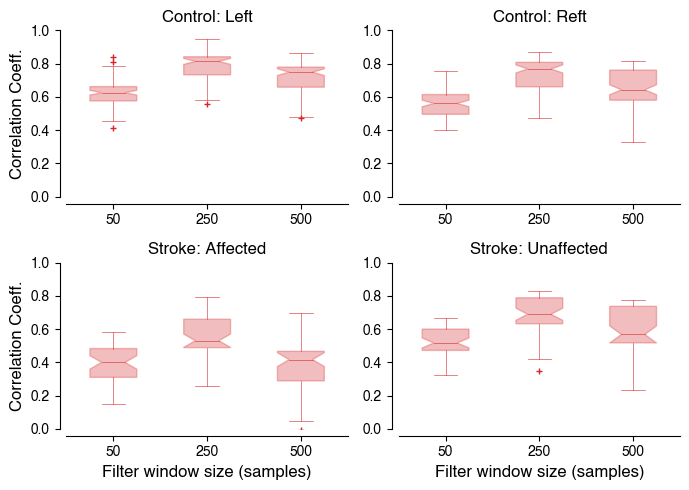

In [25]:
# Effect nam
fig = plt.figure(figsize=(7, 5))
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 2, j+1)
    for i, _val in enumerate(am_param_ranges["nam"]):
        _inx = am_corr_df[_lmb]["nam"] == _val
        _r = am_corr_df[_lmb][_inx]["r"].values
        ax.boxplot(x=_r, positions=[i],
                   widths=0.5, notch=True, patch_artist=True,
                   boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
                   capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                   whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                   flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                                   markerfacecolor='tab:red', marker='+', markersize=4),
                   medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
        ax.set_ylim(0.0, 1.0)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        if _lmb == "left":
            ax.set_title("Control: Left", fontsize=12)
        elif _lmb == "right":
            ax.set_title("Control: Reft", fontsize=12)
        elif _lmb == "aff":
            ax.set_title("Stroke: Affected", fontsize=12)
        else:
            ax.set_title("Stroke: Unaffected", fontsize=12)
        
        if j // 2 == 1:
            ax.set_xlabel("Filter window size (samples)", fontsize=12)
        if j % 2 == 0:
            ax.set_ylabel("Correlation Coeff.", fontsize=12)

    ax.set_xticklabels(am_param_ranges["nam"])
plt.tight_layout()

## Statitical Analysis of the parameters

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [19]:
am_corr_df["left"]["subj"] = am_corr_df["left"]["subj"].astype(int)
am_corr_df["left"]["nam"] = am_corr_df["left"]["nam"].astype(int)
am_corr_df["right"]["subj"] = am_corr_df["right"]["subj"].astype(int)
am_corr_df["right"]["nam"] = am_corr_df["right"]["nam"].astype(int)
am_corr_df["aff"]["subj"] = am_corr_df["aff"]["subj"].astype(int)
am_corr_df["aff"]["nam"] = am_corr_df["aff"]["nam"].astype(int)
am_corr_df["unaff"]["subj"] = am_corr_df["unaff"]["subj"].astype(int)
am_corr_df["unaff"]["nam"] = am_corr_df["unaff"]["nam"].astype(int)

In [20]:
lme_left = smf.mixedlm("r ~ fc + nc + nam", data=am_corr_df["left"],
                       groups=am_corr_df["left"]["subj"])
lme_left.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: r       
No. Observations: 270     Method:             REML    
No. Groups:       10      Scale:              0.0085  
Min. group size:  27      Log-Likelihood:     231.0468
Max. group size:  27      Converged:          Yes     
Mean group size:  27.0                                
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.630    0.022 28.608 0.000  0.587  0.673
fc           0.063    0.013  4.985 0.000  0.038  0.087
nc           0.001    0.004  0.219 0.827 -0.008  0.010
nam          0.000    0.000  6.464 0.000  0.000  0.000
Group Var    0.003    0.015                           
======================================================

"""

In [21]:
lme_right = smf.mixedlm("r ~ fc + nc + nam", data=am_corr_df["right"],
                       groups=am_corr_df["right"]["subj"])
lme_right.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: r       
No. Observations: 270     Method:             REML    
No. Groups:       10      Scale:              0.0102  
Min. group size:  27      Log-Likelihood:     206.3342
Max. group size:  27      Converged:          Yes     
Mean group size:  27.0                                
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.579    0.024 24.180 0.000  0.532  0.626
fc           0.041    0.014  2.961 0.003  0.014  0.068
nc           0.003    0.005  0.646 0.518 -0.006  0.013
nam          0.000    0.000  5.613 0.000  0.000  0.000
Group Var    0.003    0.016                           
======================================================

"""

In [26]:
lme_aff = smf.mixedlm("r ~ fc + nc + nam", data=am_corr_df["aff"],
                       groups=am_corr_df["aff"]["subj"])
lme_aff.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
=====================================================
Model:            MixedLM Dependent Variable: r      
No. Observations: 135     Method:             REML   
No. Groups:       5       Scale:              0.0189 
Min. group size:  27      Log-Likelihood:     54.3067
Max. group size:  27      Converged:          Yes    
Mean group size:  27.0                               
-----------------------------------------------------
           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept   0.456    0.054  8.445 0.000  0.350  0.562
fc          0.008    0.026  0.284 0.776 -0.044  0.059
nc         -0.002    0.009 -0.212 0.832 -0.021  0.017
nam        -0.000    0.000 -0.422 0.673 -0.000  0.000
Group Var   0.010    0.053                           
=====================================================

"""

In [24]:
lme_unaff = smf.mixedlm("r ~ fc + nc + nam", data=am_corr_df["unaff"],
                       groups=am_corr_df["unaff"]["subj"])
lme_unaff.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
=====================================================
Model:            MixedLM Dependent Variable: r      
No. Observations: 135     Method:             REML   
No. Groups:       5       Scale:              0.0117 
Min. group size:  27      Log-Likelihood:     85.3161
Max. group size:  27      Converged:          Yes    
Mean group size:  27.0                               
-----------------------------------------------------
            Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept   0.548    0.044 12.339 0.000  0.461  0.635
fc          0.069    0.021  3.320 0.001  0.028  0.110
nc          0.001    0.007  0.129 0.898 -0.014  0.016
nam         0.000    0.000  1.742 0.082 -0.000  0.000
Group Var   0.007    0.047                           
=====================================================

"""

In [32]:
left_amdf

,subject,fc,nc,nam,am,vm
7800,2.0,0.1,1.0,250.0,2.446145,NaN
7801,2.0,0.1,1.0,250.0,8.642207,NaN
7802,2.0,0.1,1.0,250.0,12.135021,NaN
7803,2.0,0.1,1.0,250.0,14.006585,NaN
7804,2.0,0.1,1.0,250.0,15.042703,188.0
...,...,...,...,...,...,...
50600,5.0,0.1,1.0,250.0,15.577424,39.0
50601,5.0,0.1,1.0,250.0,17.393389,40.0
50602,5.0,0.1,1.0,250.0,17.527661,48.0
50603,5.0,0.1,1.0,250.0,19.391116,61.0


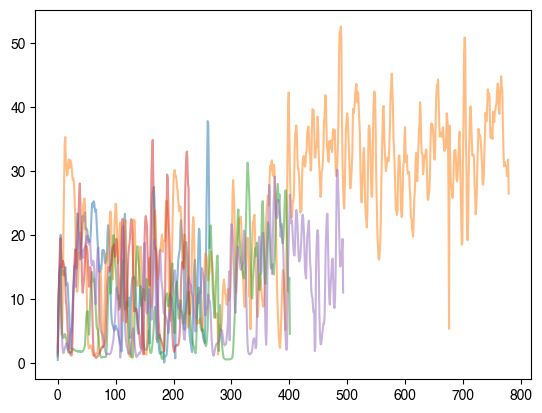

In [36]:
# [0.1],
# "nc": [1],
# "nam": [int(5*Fs)],
left_amdf = all_am_df["unaff"]
_inx1 = left_amdf["fc"] == 0.1
_inx2 = left_amdf["nc"] == 1
_inx3 = left_amdf["nam"] == int(5*Fs)
left_amdf = left_amdf[_inx1 & _inx2 & _inx3]
for _x, _y in left_amdf.groupby("subject"):
    plt.plot(_y["am"].values, alpha=0.51)

(array([1708.,  793.,  726.,  720.,  585.,  283.,   64.,   28.,   11.,
           8.]),
 array([ 0.0936103 ,  5.52951641, 10.96542252, 16.40132862, 21.83723473,
        27.27314084, 32.70904694, 38.14495305, 43.58085916, 49.01676526,
        54.45267137]),
 <BarContainer object of 10 artists>)

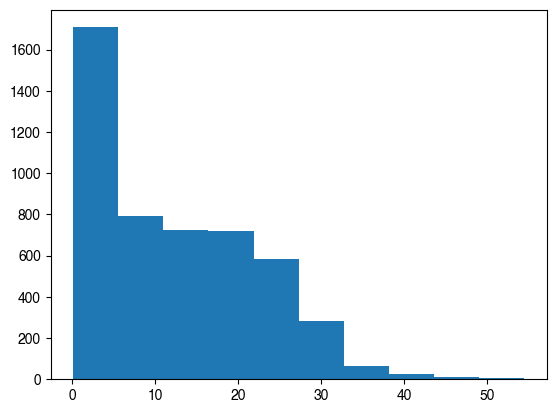

In [37]:
plt.hist(left_amdf["am"].values)